# Simulate force profiles for a dual frequency MOT for CaF

In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1662


In [3]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

In [4]:
λ = 606e-9
Γ = 2π * (1 / 19.2e-9) / 2π # in units of MHz
m = @with_unit 59 "u"
k = 2π / λ
;

## Load $\tilde{X}(v=0)$ and $\tilde{A}(v=0)$ Hamiltonians

In [346]:
HX = load_from_file("CaF_v0_N0to3_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaF\\")
HA = load_from_file("CaF_A_v0_J12to52_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaF\\")

HX_N1 = subspace(HX, (N=1,))
HA_J12 = subspace(HA, (J=1/2,))
HA_J12_pos_parity_states = HA_J12.states[5:8]

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX_N1 = add_to_H(HX_N1, :B_z, gS * _μB * Zeeman_z)
HX_N1.parameters.B_z = 1e-6

full_evaluate!(HX_N1); QuantumStates.solve!(HX_N1)
full_evaluate!(HA_J12); QuantumStates.solve!(HA_J12)

# Convert A states from Hund's case (a) to case (b) 
# We'll use the bending mode Hamiltonian for CaOH which has all basis states needed for the conversion
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX_N1.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX_N1.states; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end
;

## Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaF

In [347]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [348]:
Bs = 0:0.01:20
scan_values = (
    B_z = Bs,
    );
iterator = Iterators.product
@time x, _ = scan_parameters(deepcopy(HX_N1), scan_values, iterator, H_func!, HX_N1 -> energy.(HX_N1.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.231386 seconds (302.82 k allocations: 51.984 MiB, 64.49% compilation time)


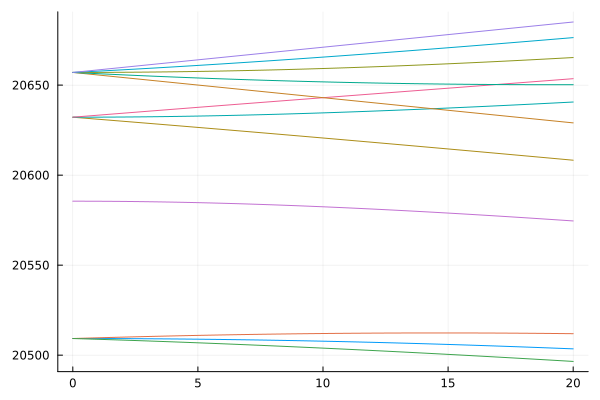

In [349]:
plot(Bs, hcat(values(x)...)', legend=nothing)

In [350]:
function g_factor(H)
    ΔB = 1e-6
    
    evaluate!(H)
    QuantumStates.solve!(H)
    bare_energies = energy.(H.states)
    
    H.parameters.B_z += ΔB
    evaluate!(H)
    QuantumStates.solve!(H)
    B_energies = energy.(H.states)

    # `H` needs to be "reset" for the next calculation
    H.parameters.B_z -= ΔB
    
    return (B_energies .- bare_energies) ./ ΔB
end

g_factor (generic function with 1 method)

In [351]:
Bs = 0:0.01:40
scan_values = (
    B_z = Bs,
    );
iterator = Iterators.product
@time x, _ = scan_parameters(deepcopy(HX_N1), scan_values, iterator, H_func!, g_factor, n_threads=1)
;

  0.604543 seconds (1.08 M allocations: 268.921 MiB, 27.62% compilation time: 100% of which was recompilation)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


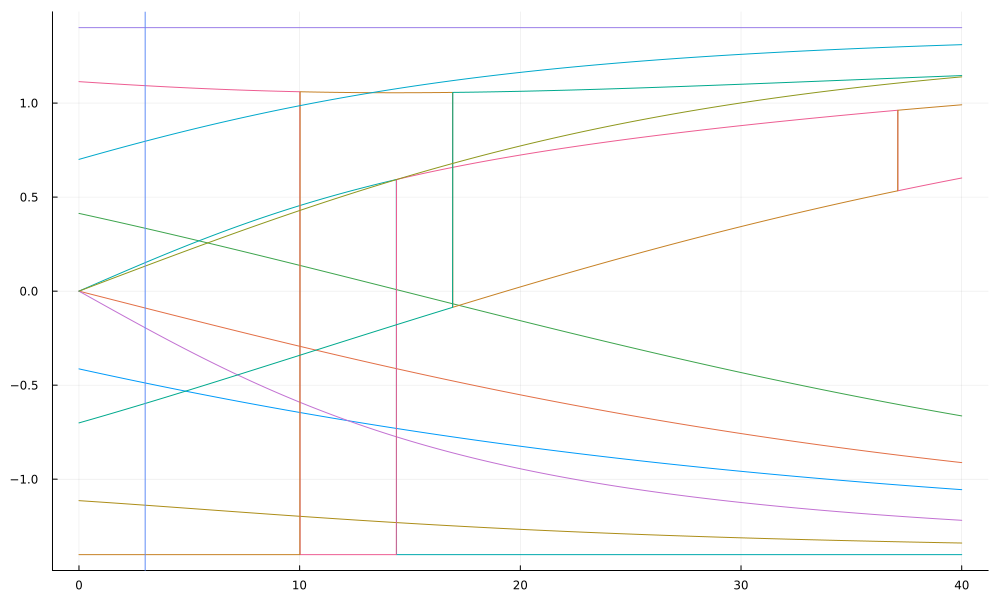

In [352]:
plot(Bs, hcat(values(x)...)', legend=nothing, size=(1000,600))
vline!([3])

## Set up parameters for the simulation

In [353]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX_N1.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX_N1.states, states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

## Laser parameters

In [369]:
# Laser parameters

# CaOH MOT settings
I = 456 / 24 # 4 frequency components, 6 directions
Isat = 4.9
# Isat = π * h * c * (Γ/2π) / (3λ^3)
s = I / Isat

# Single frequency cooling parameters
# det = -0.64Γ
# det = 2.61Γ
# pol_F1⁻ = σ⁻
# pol_F0  = σ⁻
# pol_F1⁺ = σ⁺
# pol_F2  = σ⁻

det = -0.64Γ
pol_F1⁻ = σ⁻
pol_F0  = σ⁻
pol_F1⁺ = σ⁺
pol_F2  = σ⁻

A_energy = energy(states[13])
ω_F1⁻ = 2π * (A_energy - energy(states[1])) + det
ω_F0  = 2π * (A_energy - energy(states[4])) + det
ω_F1⁺ = 2π * (A_energy - energy(states[5])) + det
ω_F2  = 2π * (A_energy - energy(states[8])) + det

ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ(rotate_pol(pol_F1⁻, +x̂)); laser1 = Field(+x̂, ϵ1, ω_F1⁻, s)
ϵ2 = ϵ(rotate_pol(pol_F1⁻, -x̂)); laser2 = Field(-x̂, ϵ2, ω_F1⁻, s)
ϵ3 = ϵ(rotate_pol(pol_F1⁻, +ŷ)); laser3 = Field(+ŷ, ϵ3, ω_F1⁻, s)
ϵ4 = ϵ(rotate_pol(pol_F1⁻, -ŷ)); laser4 = Field(-ŷ, ϵ4, ω_F1⁻, s)
ϵ5 = ϵ(rotate_pol(pol_F1⁻, +ẑ)); laser5 = Field(+ẑ, ϵ5, ω_F1⁻, s)
ϵ6 = ϵ(rotate_pol(pol_F1⁻, -ẑ)); laser6 = Field(-ẑ, ϵ6, ω_F1⁻, s)
lasers_F1⁻ = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ(rotate_pol(pol_F0, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_F0, s)
ϵ8  = ϵ(rotate_pol(pol_F0, -x̂)); laser8  = Field(-x̂, ϵ8,  ω_F0, s)
ϵ9  = ϵ(rotate_pol(pol_F0, +ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_F0, s)
ϵ10 = ϵ(rotate_pol(pol_F0, -ŷ)); laser10 = Field(-ŷ, ϵ10, ω_F0, s)
ϵ11 = ϵ(rotate_pol(pol_F0, +ẑ)); laser11 = Field(+ẑ, ϵ11, ω_F0, s)
ϵ12 = ϵ(rotate_pol(pol_F0, -ẑ)); laser12 = Field(-ẑ, ϵ12, ω_F0, s)
lasers_F0 = [laser7, laser8, laser9, laser10, laser11, laser12]

ϵ13 = ϵ(rotate_pol(pol_F1⁺, +x̂)); laser13 = Field(+x̂, ϵ13, ω_F1⁺, s)
ϵ14 = ϵ(rotate_pol(pol_F1⁺, -x̂)); laser14 = Field(-x̂, ϵ14, ω_F1⁺, s)
ϵ15 = ϵ(rotate_pol(pol_F1⁺, +ŷ)); laser15 = Field(+ŷ, ϵ15, ω_F1⁺, s)
ϵ16 = ϵ(rotate_pol(pol_F1⁺, -ŷ)); laser16 = Field(-ŷ, ϵ16, ω_F1⁺, s)
ϵ17 = ϵ(rotate_pol(pol_F1⁺, +ẑ)); laser17 = Field(+ẑ, ϵ17, ω_F1⁺, s)
ϵ18 = ϵ(rotate_pol(pol_F1⁺, -ẑ)); laser18 = Field(-ẑ, ϵ18, ω_F1⁺, s)
lasers_F1⁺ = [laser13, laser14, laser15, laser16, laser17, laser18]

ϵ19 = ϵ(rotate_pol(pol_F2, +x̂)); laser19 = Field(+x̂, ϵ19, ω_F2, s)
ϵ20 = ϵ(rotate_pol(pol_F2, -x̂)); laser20 = Field(-x̂, ϵ20, ω_F2, s)
ϵ21 = ϵ(rotate_pol(pol_F2, +ŷ)); laser21 = Field(+ŷ, ϵ21, ω_F2, s)
ϵ22 = ϵ(rotate_pol(pol_F2, -ŷ)); laser22 = Field(-ŷ, ϵ22, ω_F2, s)
ϵ23 = ϵ(rotate_pol(pol_F2, +ẑ)); laser23 = Field(+ẑ, ϵ23, ω_F2, s)
ϵ24 = ϵ(rotate_pol(pol_F2, -ẑ)); laser24 = Field(-ẑ, ϵ24, ω_F2, s)
lasers_F2 = [laser19, laser20, laser21, laser22, laser23, laser24]

lasers = [lasers_F1⁻; lasers_F0; lasers_F1⁺; lasers_F2]
;

## Set up a single run of the OBEs

In [370]:
# Set initial conditions
particle = Particle()
particle.r0 = (0.0, 0.0, 0.0)
particle.v = (0.0, 0.0, 0.0)

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[1,1] = 1.0

extra_p = (basis_tdms=basis_tdms, HX_N1=HX_N1, d_ge=d_ge)
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.B = (0., 0., 0.) ./ (Γ / (_μB * 1e6))
p.r0 = (0.0, 0.0, 0.0) .* 2π
p.v = (0., 0., 0.3) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [371]:
# using BenchmarkTools
# dρ = deepcopy(ρ0)
# @time ρ!(dρ, ρ0, p, 0.3)
# @btime ρ!($dρ, $ρ0, $p, 0.3)

In [372]:
t_end = 20p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [373]:
cb = PeriodicCallback(reset_force!, p.period)
prob.p.force_last_period = (0, 0, 0)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, abstol=1e-5)
;

  9.179886 seconds (15.73 M allocations: 2.048 GiB, 16.96% gc time, 91.09% compilation time)


In [374]:
sol.t[end], t_end

(1884.9555921538758, 12567.370614359173)

In [375]:
using Plots
plot_us = sol.u[1:1:end]
plot_ts = sol.t[1:1:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [376]:
(1e-3 * ħ * k * Γ / m) .* p.force_last_period

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -0.0012002404151128937
 -0.00046831793315466676
 -1.7782486711126095

## Force versus velocity

In [377]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= sample_direction(scan_values.v[i]) #(0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return f_proj #isnan(f_proj) ? 0.0 : f_proj
end
;

In [378]:
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 100p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 200

prob.p.B .= (0.0, 0.0, 0.0)
# vs = repeat(collect(0:2:40), n_samples) ./ (Γ / k)
# vs = repeat([collect(0:0.01:0.1); collect(0.2:0.1:1.0)], n_samples) ./ (Γ / k)
vs = repeat(0:1:40, n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26

 26.822140 seconds (990.17 k allocations: 901.126 MiB, 0.45% gc time)


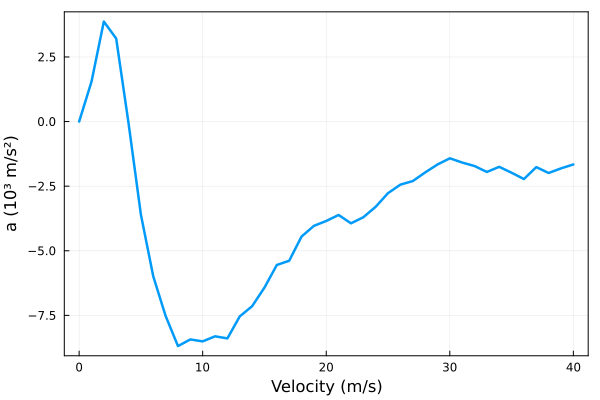

In [382]:
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

vs, averaged_forces = average_forces(scan_params, forces)
averaged_forces[1] = 0.0
η = 1.29
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces ./ η,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    # ylim=(-14, 11),
    linewidth=2.5,
    legend=nothing)

## Force versus magnetic field

In [22]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values.Bz[i]
    if p.extra_p.HX_N1.parameters.B_z != Bz
        # prob.p.B .= (0.0, 0.0, Bz)
        p.B .= (0., 0., 0.)
        p.extra_p.HX_N1.parameters.B_z = Bz .* (p.Γ / (_μB * 1e6))
        evaluate!(p.extra_p.HX_N1)
        QuantumStates.solve!(p.extra_p.HX_N1)
        for i ∈ eachindex(p.extra_p.HX_N1.states)
            p.extra_p.HX_N1.states[i].E *= 1e6
        end

        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX_N1.states, p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX_N1.states; p.extra_p.states_A_J12_caseB]

        extra_p = (HX_N1=p.extra_p.HX_N1, states_A_J12_caseB=p.extra_p.states_A_J12_caseB, d_ge=p.extra_p.d_ge)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d_m, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= sample_direction(0.0)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.v .= (0., 0., 0.) #scan_values.v[i]
    # new_p.r0 .= scan_values.r[i]
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function param_func(p, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [23]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX_N1=HX_N1, states_A_J12_caseB=states_A_J12_caseB, d_ge=d_ge)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 100p.period+1; tspan = (0., t_end)
# prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

Bzs = (0:5:30) ./ (Γ / (_μB * 1e6))
# rs = vec([[rx, ry, rz] for rx in (0:1/16:0.95), ry in (0:1/16:0.95), rz in (0:1/16:0.95)])
# vs = [0.0]
# iterator = Iterators.product(Bzs, rs, vs)

n_samples = 1000

scan_values = (Bz = repeat(Bzs, n_samples),)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


 37.137561 seconds (6.62 M allocations: 1.820 GiB, 2.77% compilation time: 22% of which was recompilation)


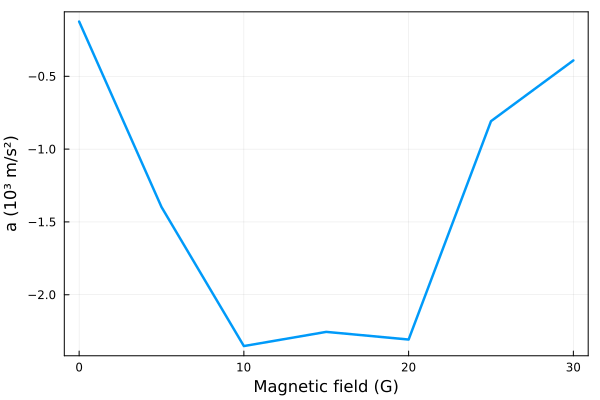

In [24]:
@time scan_params, forces_red_magnetic = force_scan(prob, scan_values, prob_func!, param_func, output_func)

Bzs, averaged_forces = average_forces(scan_params, forces_red_magnetic)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    legend=nothing)